# Neural Networks for TKN Prediction in Influent Wastewater

Model Iteration No. 1 - This code uses all project feature inputs (BOD5, CBOD5, VTS, SS, VSS, TS, P-TOT, P-SOL). This code served as the first step prior to SHAP value evaluations. See appendix D for Model Iteration No. 2 which is the final project model.

In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential 

In [78]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [79]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [260]:
influent = pd.read_excel(r"C:\Users\18455\EAEE4000_ML_Jupyter\EAEE4000_WW_Prediction\Appendix_A_Preprocessing_and_DataReview\raw_influent.xlsx")
influent

,Unnamed: 0,Date,BOD5,CBOD5,SS,VSS,TS,VTS,TKN,Nitrates,P-TOT,P-SOL
0,2672,2008-01-01,67,55,82,64,1994,188,18.53,0.72,2.65,1.155
1,2673,2008-01-02,77,57,70,61,1274,196,19.87,0.85,4.22,2.849
2,2674,2008-01-03,94,70,84,69,1096,220,21.49,0.81,5.53,3.809
3,2675,2008-01-04,93,64,72,54,1003,242,19.32,0.65,6.19,4.107
4,2676,2008-01-05,107,75,118,90,1317,280,17.13,0.31,4.16,2.183
...,...,...,...,...,...,...,...,...,...,...,...,...
4378,7706,2019-12-27,0,0,79,61,554,174,14.00,0.66,3.05,1.310
4379,7707,2019-12-28,62,51,48,37,570,130,18.00,0.76,4.47,2.170
4380,7708,2019-12-29,189,115,340,224,962,340,17.00,0.49,4.55,1.240
4381,7709,2019-12-30,74,47,99,68,656,164,14.00,0.88,2.70,1.070


# Prepare the Training Data

See all project input features used here.

In [261]:
# Prepare the training set
X = influent[['SS','VSS','VTS','TS','BOD5','CBOD5', 'P-TOT','P-SOL']]
Y = influent[['TKN']] 
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y,
        test_size = 0.2, random_state=4, shuffle=True)

In [262]:
# Normalize the data
mean_x, std_x = X_train_df.mean(), X_train_df.std()
mean_y, std_y = Y_train_df.mean(), Y_train_df.std()

X_train_df = (X_train_df - mean_x)/std_x
X_test_df  = (X_test_df - mean_x)/std_x

Y_train_df = (Y_train_df - mean_y)/std_y
Y_test_df  = (Y_test_df - mean_y)/std_y

X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

X_test = X_test_df.to_numpy()
Y_test = Y_test_df.to_numpy()

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape, )

(3506, 8) (3506, 1)
(877, 8) (877, 1)


# Set Hyperparameters and Model Architecture

In [294]:
# set hyperparameters
n_neuron       = 4
activation     = 'relu' 
num_epochs     = 50
learning_rate  = 0.007
minibatch_size = 80 
model_num      = 1

In [300]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 5th hidden layer, Not used - determined additional layers did not improve accuracy.
#model.add(Dense(n_neuron,  activation=activation)) # the 6th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 7th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 8th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 9th hidden layer
#model.add(Dense(n_neuron,  activation=activation)) # the 10th hidden layer
model.add(Dense(Y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)) # MSE much better than MAE

In [301]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_242 (Dense)           (None, 4)                 36        
                                                                 
 dense_243 (Dense)           (None, 4)                 20        
                                                                 
 dense_244 (Dense)           (None, 4)                 20        
                                                                 
 dense_245 (Dense)           (None, 4)                 20        
                                                                 
 dense_246 (Dense)           (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


# Evaluate the Model

In [302]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, Y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1, 
                    callbacks       = [early_stop])

Epoch 1/50
36/36 [==============================] - 1s 12ms/step - loss: 0.7474 - val_loss: 1.2901
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.5952 - val_loss: 0.9606
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.4667 - val_loss: 0.8657
Epoch 4/50
36/36 [==============================] - 0s 5ms/step - loss: 0.4260 - val_loss: 0.9220
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3882 - val_loss: 0.7657
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3531 - val_loss: 0.7603
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3464 - val_loss: 0.8196
Epoch 8/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3322 - val_loss: 0.7505
Epoch 9/50
36/36 [==============================] - 0s 4ms/step - loss: 0.3106 - val_loss: 0.6863
Epoch 10/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2969 - val_loss: 0.6694
Epoch 11/50
36/36 

In [303]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
            label='Train loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
            label='Val loss')
    plt.legend()

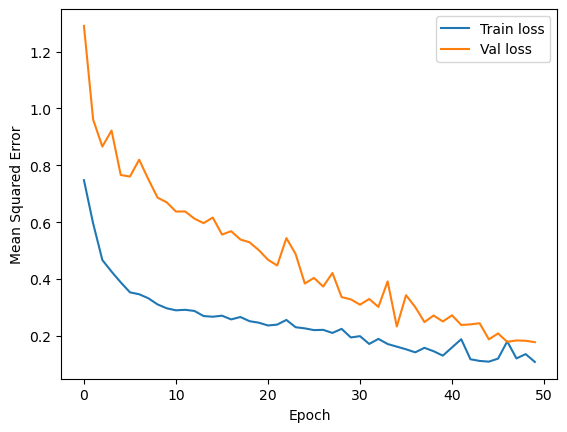

In [304]:
plot_history(history)

# Make Predictions

In [305]:
y_test_predict = model.predict(X_test)
y_test_predict

28/28 [==============================] - 0s 2ms/step


array([[-4.83877897e-01],
       [ 1.08622015e-01],
       [ 2.72479653e-02],
       [-5.71152449e-01],
       [-4.64843750e-01],
       [-8.00042033e-01],
       [-4.91686821e-01],
       [-8.45848918e-01],
       [ 3.30713600e-01],
       [-1.25721157e-01],
       [ 6.15422368e-01],
       [ 3.54795009e-01],
       [-2.34880924e-01],
       [-3.59763503e-01],
       [-1.98154867e-01],
       [-6.44761324e-02],
       [ 1.48184299e-02],
       [-2.37742841e-01],
       [ 6.20264411e-02],
       [-9.22576785e-02],
       [ 5.02765954e-01],
       [-5.31504869e-01],
       [ 2.81159520e-01],
       [ 8.23321998e-01],
       [-5.78431606e-01],
       [ 1.93945050e-01],
       [ 2.64105511e+00],
       [ 7.11475015e-02],
       [-4.31777716e-01],
       [-1.90820456e-01],
       [ 1.54044592e+00],
       [-5.46480298e-01],
       [ 4.55848277e-01],
       [-1.16649032e-01],
       [-3.91147733e-01],
       [-4.19100404e-01],
       [ 1.74425352e+00],
       [-7.24691272e-01],
       [ 2.6

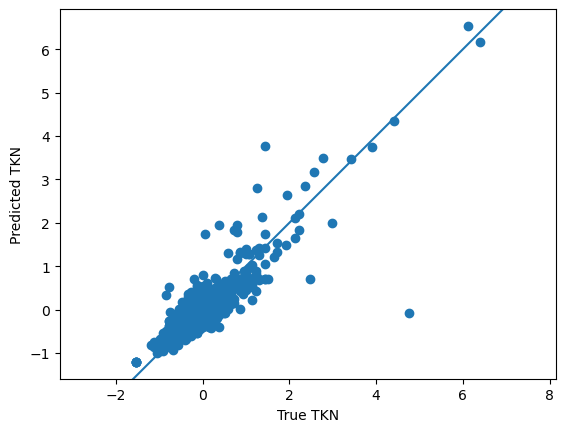

In [310]:
plt.scatter(Y_test, y_test_predict) # this is where y_test comes into play
plt.xlabel('True TKN')
plt.ylabel('Predicted TKN')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [307]:
# Calculate predictions & associated Mean Squared Error
mse(Y_test, y_test_predict)

0.12028842259775609

In [308]:
# print out the prediction scores
print('MSE: {}'.format(mse(Y_test, y_test_predict)))
print('RMSE: {}'.format(np.sqrt(mse(Y_test, y_test_predict))))
print('MAE: {}'.format(mae(Y_test, y_test_predict)))
print('R-SQ: {}'.format(r2_score(Y_test, y_test_predict)))

MSE: 0.12028842259775609
RMSE: 0.3468262138272655
MAE: 0.22244580161868843
R-SQ: 0.7716219972333367


In [309]:
model.get_weights()

[array([[ 0.03349807,  1.1277958 ,  0.00527048,  0.32801908],
        [ 0.5449326 , -0.2693366 ,  0.04389728,  0.9453227 ],
        [-0.355409  , -0.82006603,  0.06029933,  0.9478927 ],
        [-0.40427056,  0.00330584,  0.1961991 ,  0.11616972],
        [ 0.8308283 , -1.0539328 , -0.22328754, -1.4036912 ],
        [ 0.11125273, -0.9006469 , -0.20976536, -0.33641118],
        [ 0.8861007 , -0.12372942,  1.5367527 , -0.28406587],
        [-0.36684662, -0.26170918,  0.21403953,  0.14877002]],
       dtype=float32),
 array([ 0.6277163 ,  0.14997216, -0.99675477, -0.79652137], dtype=float32),
 array([[-0.64277345, -0.14835295,  0.36262083, -0.4010983 ],
        [-1.5497425 , -0.94995505,  0.75657916,  0.5906935 ],
        [ 0.5720857 , -0.7403422 ,  0.8576693 ,  0.0179214 ],
        [ 0.38907766, -0.18594757, -0.5518939 , -1.3637207 ]],
       dtype=float32),
 array([-1.511506  , -0.13248375,  0.27768156,  1.1000372 ], dtype=float32),
 array([[ 0.02237999, -0.07352289, -1.3414602 , -0.365